In [307]:
from tools import *
from K_exp import *
from K_shift import *
from K_frac import *
from quantization import *
from calibration_tools import *

### I. $K^{\text{frac}}$ kernel 

In [3]:
from scipy.stats import norm

def HERE_BS_price_vectorized_OTM(S, sigma, T, K_array, S0):
    """
    S : (M,)         — prix terminal simulé
    sigma : (M,)     — vol par trajectoire
    T : float
    K_array : (len_K,) — strikes
    S0 : float       — prix spot initial, pour déterminer le type d’option OTM
    """

    M = S.shape[0]
    len_K = K_array.shape[0]

    S_matrix = S[:, None]         # (M, 1)
    sigma_matrix = sigma[:, None]  # (M, 1)
    K_matrix = K_array[None, :]   # (1, len_K)

    logmoneyness = np.log(K_array / S0)  # shape (len_K,)
    put_mask = logmoneyness < 0          # shape (len_K,)

    put_mask_matrix = np.broadcast_to(put_mask, (M, len_K))

    with np.errstate(divide='ignore', invalid='ignore'):
        d1 = (np.log(S_matrix / K_matrix) + 0.5 * sigma_matrix**2 * T) / (sigma_matrix * np.sqrt(T))
        d2 = d1 - sigma_matrix * np.sqrt(T)

    zero_sigma = sigma_matrix == 0
    zero_matrix = np.broadcast_to(zero_sigma, (M, len_K))

    call_prices = S_matrix * norm.cdf(d1) - K_matrix * norm.cdf(d2)
    put_prices = K_matrix * norm.cdf(-d2) - S_matrix * norm.cdf(-d1)

    call_zero = np.maximum(S_matrix - K_matrix, 0)
    put_zero = np.maximum(K_matrix - S_matrix, 0)

    call_prices = np.where(zero_matrix, call_zero, call_prices)
    put_prices = np.where(zero_matrix, put_zero, put_prices)

    prices = np.where(put_mask_matrix, put_prices, call_prices)

    return prices

#### I.1. $M = 5000$

In [208]:
rho = -0.8
alphas = [0, 1, 0, 0, 0, 0]
m = len(alphas) - 1 
n = 500
M = 5000
H = 0.2
T = 1
S0 = 100

In [210]:
b_star = compute_b_star(n, H)
cov = compute_covariance(n, T, H, rho)
W_vals = compute_B(M, n, T, H, rho)
c_array_full = compute_c_array(n, T, H, b_star) 
X = simulate_X_frac(M, n, T, c_array_full, W_vals)

In [211]:
t_grid = np.linspace(0, T, n+1) 
xi = [0.02] * len(t_grid) 
g = compute_g_frac(t_grid, m, alphas, H)
p = eval_polynomial(X, alphas)
sigma = compute_sigma(X, p, xi, g, alphas)

In [214]:
Y = W_vals[:, :, 0] * np.sqrt(n/T) 
Y_ = simulate_antithetic(M, n)
S = simulate_S(M, n, T, sigma, S0, rho, Y, Y_)

In [216]:
partial_S = simulate_partial_S(M, n, T, sigma, S0, rho, Y)

In [218]:
lm_range = np.linspace(-0.75, 0.25, 50)
iv_mc_5k = []
iv_mc_upper_5k = []
iv_mc_lower_5k = []
K_range = np.exp(lm_range) * S0 

for lm in lm_range :
    if lm > 0 :
        call_mc, _, call_mc_lower, call_mc_upper = monte_carlo(np.maximum(S[:,-1] - np.exp(lm) * S0, 0.0))
        iv_mc_5k.append(safe_implied_volatility(call_mc, S0, np.exp(lm)*S0, T, 0, "c"))
        iv_mc_upper_5k.append(safe_implied_volatility(call_mc_upper, S0, np.exp(lm)*S0, T, 0, "c"))
        iv_mc_lower_5k.append(safe_implied_volatility(call_mc_lower, S0, np.exp(lm)*S0, T, 0, "c"))
    else : 
        put_mc, _, put_mc_lower, put_mc_upper = monte_carlo(np.maximum(np.exp(lm)*S0-S[:,-1], 0.0))
        iv_mc_5k.append(safe_implied_volatility(put_mc, S0, np.exp(lm)*S0, T, 0, "p"))
        iv_mc_upper_5k.append(safe_implied_volatility(put_mc_upper, S0, np.exp(lm)*S0, T, 0, "p"))
        iv_mc_lower_5k.append(safe_implied_volatility(put_mc_lower, S0, np.exp(lm)*S0, T, 0, "p"))

In [220]:
iv_turbo_5k, iv_turbo_lower_5k, iv_turbo_upper_5k = turbocharging(K_range, partial_S, S0, sigma, rho, T, n) 

#### I.2. $M = 50000$

In [222]:
rho = -0.8
alphas = [0, 1, 0, 0, 0, 0]
m = len(alphas) - 1 
n = 500
M = 50000
H = 0.2
T = 1
S0 = 100

In [224]:
b_star = compute_b_star(n, H)
cov = compute_covariance(n, T, H, rho)
W_vals = compute_B(M, n, T, H, rho)
c_array_full = compute_c_array(n, T, H, b_star) 
X = simulate_X_frac(M, n, T, c_array_full, W_vals)

In [225]:
t_grid = np.linspace(0, T, n+1) 
xi = [0.02] * len(t_grid) 
g = compute_g_frac(t_grid, m, alphas, H)
p = eval_polynomial(X, alphas)
sigma = compute_sigma(X, p, xi, g, alphas)

In [226]:
Y = W_vals[:, :, 0] * np.sqrt(n/T) 
Y_ = simulate_antithetic(M, n)
S = simulate_S(M, n, T, sigma, S0, rho, Y, Y_)

In [227]:
partial_S = simulate_partial_S(M, n, T, sigma, S0, rho, Y)

In [228]:
lm_range = np.linspace(-0.75, 0.25, 50)
iv_mc_50k = []
iv_mc_upper_50k = []
iv_mc_lower_50k = []
K_range = np.exp(lm_range) * S0 

for lm in lm_range :
    if lm > 0 :
        call_mc, _, call_mc_lower, call_mc_upper = monte_carlo(np.maximum(S[:,-1] - np.exp(lm) * S0, 0.0))
        iv_mc_50k.append(safe_implied_volatility(call_mc, S0, np.exp(lm)*S0, T, 0, "c"))
        iv_mc_upper_50k.append(safe_implied_volatility(call_mc_upper, S0, np.exp(lm)*S0, T, 0, "c"))
        iv_mc_lower_50k.append(safe_implied_volatility(call_mc_lower, S0, np.exp(lm)*S0, T, 0, "c"))
    else : 
        put_mc, _, put_mc_lower, put_mc_upper = monte_carlo(np.maximum(np.exp(lm)*S0-S[:,-1], 0.0))
        iv_mc_50k.append(safe_implied_volatility(put_mc, S0, np.exp(lm)*S0, T, 0, "p"))
        iv_mc_upper_50k.append(safe_implied_volatility(put_mc_upper, S0, np.exp(lm)*S0, T, 0, "p"))
        iv_mc_lower_50k.append(safe_implied_volatility(put_mc_lower, S0, np.exp(lm)*S0, T, 0, "p"))

In [229]:
iv_turbo_50k, iv_turbo_lower_50k, iv_turbo_upper_50k = turbocharging(K_range, partial_S, S0, sigma, rho, T, n) 

#### I.3. Joint plot 

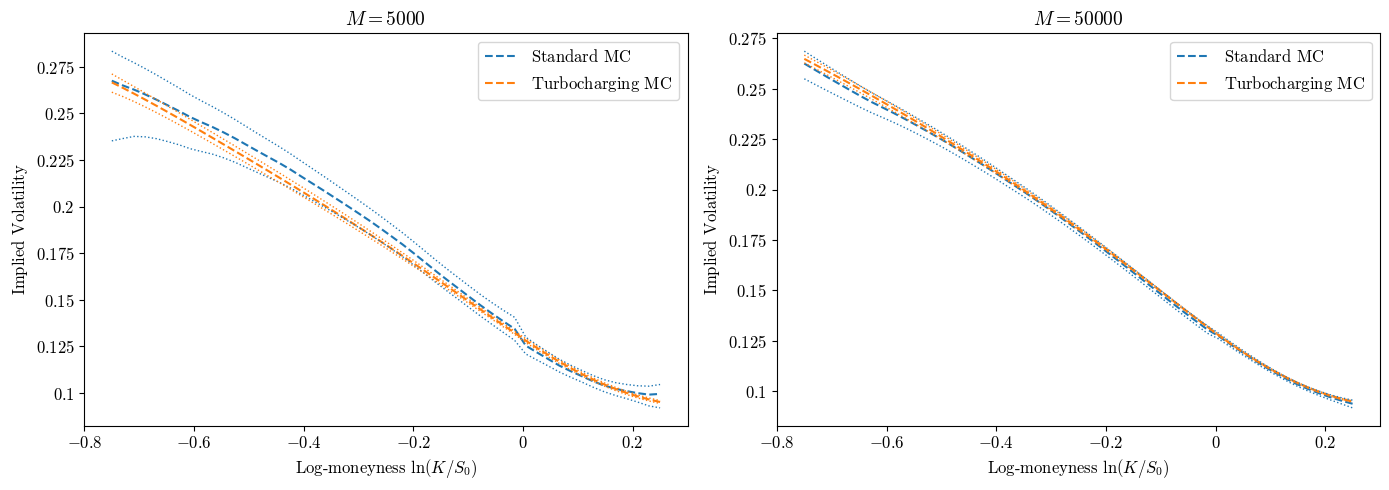

In [267]:
fig, ax = plt.subplots(1, 2, figsize = (14,5))

ax[0].plot(lm_range, iv_mc_5k, color = "tab:blue", linestyle = "--", label = r"$\text{Standard MC}$")
ax[0].plot(lm_range, iv_turbo_5k, color = "tab:orange", linestyle = "--", label = r"$\text{Turbocharging MC}$")
ax[0].plot(lm_range, iv_mc_lower_5k, color = "tab:blue", linestyle =":", lw=1)
ax[0].plot(lm_range, iv_mc_upper_5k, color = "tab:blue", linestyle =":", lw=1)
ax[0].plot(lm_range, iv_turbo_lower_5k, color = "tab:orange", linestyle =":", lw=1)
ax[0].plot(lm_range, iv_turbo_upper_5k, color = "tab:orange", linestyle =":", lw=1)
ax[0].set_title(r"$M = 5000$", fontsize=14)
ax[0].legend(fontsize=12)

ax[1].plot(lm_range, iv_mc_50k, color = "tab:blue", linestyle = "--", label = r"$\text{Standard MC}$")
ax[1].plot(lm_range, iv_turbo_50k, color = "tab:orange", linestyle = "--", label = r"$\text{Turbocharging MC}$")
ax[1].plot(lm_range, iv_mc_lower_50k, color = "tab:blue", linestyle =":", lw=1)
ax[1].plot(lm_range, iv_mc_upper_50k, color = "tab:blue", linestyle =":", lw=1)
ax[1].plot(lm_range, iv_turbo_lower_50k, color = "tab:orange", linestyle =":", lw=1)
ax[1].plot(lm_range, iv_turbo_upper_50k, color = "tab:orange", linestyle =":", lw=1)
ax[1].set_title(r"$M = 50000$", fontsize=14)
ax[1].legend(fontsize=12)

for i in range(2) : 
    ax[i].set_xlabel(r"$\text{Log-moneyness }\ln(K/S_0)$", fontsize=12)
    ax[i].set_ylabel(r"$\text{Implied Volatility}$", fontsize=12) 
    ax[i].tick_params(axis='both', labelsize=12)
    ax[i].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
    ax[i].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
    
plt.tight_layout()
plt.show()

### II. $K^\text{exp}$ kernel

#### II.1. $M= 5000$

In [369]:
H = -0.2
alphas = [0.01, 1.0, 0.0, 0.214, 0.0, 0.227]
eps = 1/52
n = 500
M = 5000

In [371]:
t_grid = np.linspace(0, T, n+1) 
xi = [0.02] * len(t_grid) 
g = compute_g_exp(t_grid, alphas, H, eps)
Y = simulate_antithetic(M, n)
X = simulate_X_exp(M, n, T, H, eps, Y)
p = eval_polynomial(X, alphas)
sigma = compute_sigma(X, p, xi, g, alphas)

In [373]:
Y_  = simulate_antithetic(M, n) 
S = simulate_S(M, n, T, sigma, S0, rho, Y, Y_)
partial_S = simulate_partial_S(M, n, T, sigma, S0, rho, Y) 

In [375]:
lm_range = np.linspace(-0.75, 0.25, 50)
iv_mc_5k = []
iv_mc_upper_5k = []
iv_mc_lower_5k = []
K_range = np.exp(lm_range) * S0 

for lm in lm_range :
    if lm > 0 :
        call_mc, _, call_mc_lower, call_mc_upper = monte_carlo(np.maximum(S[:,-1] - np.exp(lm) * S0, 0.0))
        iv_mc_5k.append(safe_implied_volatility(call_mc, S0, np.exp(lm)*S0, T, 0, "c"))
        iv_mc_upper_5k.append(safe_implied_volatility(call_mc_upper, S0, np.exp(lm)*S0, T, 0, "c"))
        iv_mc_lower_5k.append(safe_implied_volatility(call_mc_lower, S0, np.exp(lm)*S0, T, 0, "c"))
    else : 
        put_mc, _, put_mc_lower, put_mc_upper = monte_carlo(np.maximum(np.exp(lm)*S0-S[:,-1], 0.0))
        iv_mc_5k.append(safe_implied_volatility(put_mc, S0, np.exp(lm)*S0, T, 0, "p"))
        iv_mc_upper_5k.append(safe_implied_volatility(put_mc_upper, S0, np.exp(lm)*S0, T, 0, "p"))
        iv_mc_lower_5k.append(safe_implied_volatility(put_mc_lower, S0, np.exp(lm)*S0, T, 0, "p"))

In [377]:
iv_turbo_5k, iv_turbo_lower_5k, iv_turbo_upper_5k = turbocharging(K_range, partial_S, S0, sigma, rho, T, n) 

#### II.2. $M=50000$

In [380]:
H = -0.2
alphas = [0.01, 1.0, 0.0, 0.214, 0.0, 0.227]
eps = 1/52
n = 500
M = 50000

In [382]:
t_grid = np.linspace(0, T, n+1) 
xi = [0.02] * len(t_grid) 
g = compute_g_exp(t_grid, alphas, H, eps)
Y = simulate_antithetic(M, n)
X = simulate_X_exp(M, n, T, H, eps, Y)
p = eval_polynomial(X, alphas)
sigma = compute_sigma(X, p, xi, g, alphas)

In [383]:
Y_  = simulate_antithetic(M, n) 
S = simulate_S(M, n, T, sigma, S0, rho, Y, Y_)
partial_S = simulate_partial_S(M, n, T, sigma, S0, rho, Y) 

In [385]:
lm_range = np.linspace(-0.75, 0.25, 50)
iv_mc_50k = []
iv_mc_upper_50k = []
iv_mc_lower_50k = []
K_range = np.exp(lm_range) * S0 

for lm in lm_range :
    if lm > 0 :
        call_mc, _, call_mc_lower, call_mc_upper = monte_carlo(np.maximum(S[:,-1] - np.exp(lm) * S0, 0.0))
        iv_mc_50k.append(safe_implied_volatility(call_mc, S0, np.exp(lm)*S0, T, 0, "c"))
        iv_mc_upper_50k.append(safe_implied_volatility(call_mc_upper, S0, np.exp(lm)*S0, T, 0, "c"))
        iv_mc_lower_50k.append(safe_implied_volatility(call_mc_lower, S0, np.exp(lm)*S0, T, 0, "c"))
    else : 
        put_mc, _, put_mc_lower, put_mc_upper = monte_carlo(np.maximum(np.exp(lm)*S0-S[:,-1], 0.0))
        iv_mc_50k.append(safe_implied_volatility(put_mc, S0, np.exp(lm)*S0, T, 0, "p"))
        iv_mc_upper_50k.append(safe_implied_volatility(put_mc_upper, S0, np.exp(lm)*S0, T, 0, "p"))
        iv_mc_lower_50k.append(safe_implied_volatility(put_mc_lower, S0, np.exp(lm)*S0, T, 0, "p"))

In [388]:
iv_turbo_50k, iv_turbo_lower_50k, iv_turbo_upper_50k = turbocharging(K_range, partial_S, S0, sigma, rho, T, n) 

#### II.3. Joint plot 

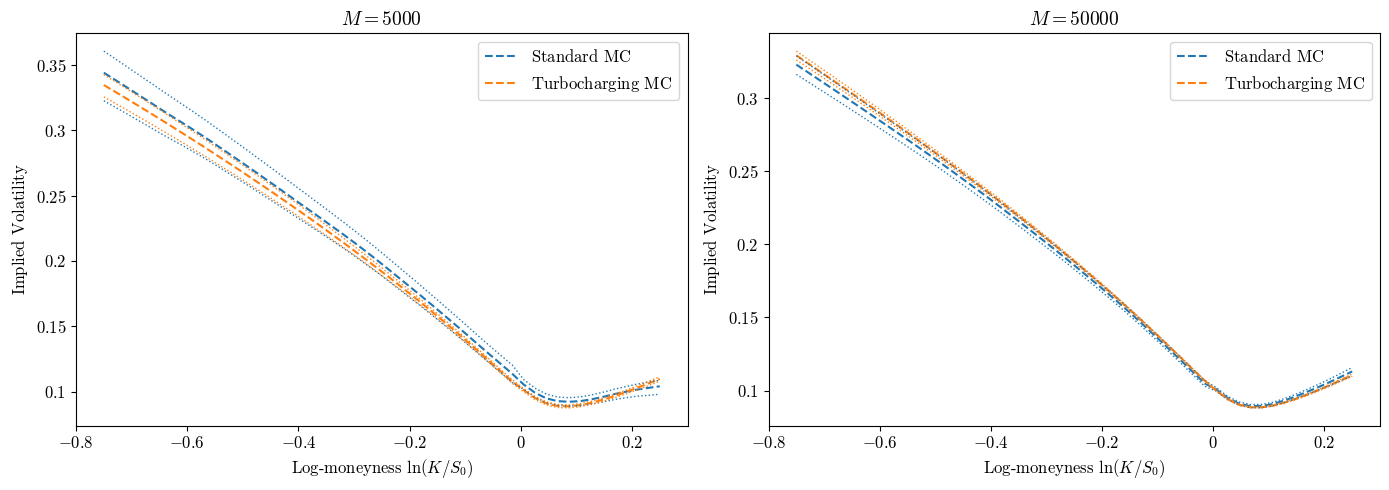

In [403]:
fig, ax = plt.subplots(1, 2, figsize = (14, 5))

ax[0].plot(lm_range, iv_mc_5k, color = "tab:blue", linestyle = "--", label = r"$\text{Standard MC}$")
ax[0].plot(lm_range, iv_turbo_5k, color = "tab:orange", linestyle = "--", label = r"$\text{Turbocharging MC}$")
ax[0].plot(lm_range, iv_mc_lower_5k, color = "tab:blue", linestyle =":", lw=1)
ax[0].plot(lm_range, iv_mc_upper_5k, color = "tab:blue", linestyle =":", lw=1)
ax[0].plot(lm_range, iv_turbo_lower_5k, color = "tab:orange", linestyle =":", lw=1)
ax[0].plot(lm_range, iv_turbo_upper_5k, color = "tab:orange", linestyle =":", lw=1)
ax[0].set_title(r"$M = 5000$", fontsize=14)
ax[0].legend(fontsize=12)

ax[1].plot(lm_range, iv_mc_50k, color = "tab:blue", linestyle = "--", label = r"$\text{Standard MC}$")
ax[1].plot(lm_range, iv_turbo_50k, color = "tab:orange", linestyle = "--", label = r"$\text{Turbocharging MC}$")
ax[1].plot(lm_range, iv_mc_lower_50k, color = "tab:blue", linestyle =":", lw=1)
ax[1].plot(lm_range, iv_mc_upper_50k, color = "tab:blue", linestyle =":", lw=1)
ax[1].plot(lm_range, iv_turbo_lower_50k, color = "tab:orange", linestyle =":", lw=1)
ax[1].plot(lm_range, iv_turbo_upper_50k, color = "tab:orange", linestyle =":", lw=1)
ax[1].set_title(r"$M = 50000$", fontsize=14)
ax[1].legend(fontsize=12)

for i in range(2) : 
    ax[i].set_xlabel(r"$\text{Log-moneyness }\ln(K/S_0)$", fontsize=12)
    ax[i].set_ylabel(r"$\text{Implied Volatility}$", fontsize=12) 
    ax[i].tick_params(axis='both', labelsize=12)
    ax[i].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
    ax[i].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")

plt.tight_layout()
plt.show()

### III. $K^{\text{shift}}$ kernel 

#### III.1. $M=5000$

In [345]:
rho = -0.7
H = -0.85
alphas = [0.103, 0.163, 0.0, 0.0001, 0.0, 5*1e-8]
eps = 1/52
n = 500
M = 5000
T = 1

In [347]:
t_grid = np.linspace(0, T, n+1) 
xi = [0.02] * len(t_grid) 
g = compute_g_exp(t_grid, alphas, H, eps)
Y = simulate_antithetic(M, n)
X = simulate_X_shift(M, n, T, H, eps, Y)
p = eval_polynomial(X, alphas)
sigma = compute_sigma(X, p, xi, g, alphas)

In [348]:
Y_  = simulate_antithetic(M, n) 
S = simulate_S(M, n, T, sigma, S0, rho, Y, Y_)
partial_S = simulate_partial_S(M, n, T, sigma, S0, rho, Y) 

In [349]:
lm_range = np.linspace(-0.75, 0.25, 50)
iv_mc_5k = []
iv_mc_upper_5k = []
iv_mc_lower_5k = []
K_range = np.exp(lm_range) * S0 

for lm in lm_range :
    if lm > 0 :
        call_mc, _, call_mc_lower, call_mc_upper = monte_carlo(np.maximum(S[:,-1] - np.exp(lm) * S0, 0.0))
        iv_mc_5k.append(safe_implied_volatility(call_mc, S0, np.exp(lm)*S0, T, 0, "c"))
        iv_mc_upper_5k.append(safe_implied_volatility(call_mc_upper, S0, np.exp(lm)*S0, T, 0, "c"))
        iv_mc_lower_5k.append(safe_implied_volatility(call_mc_lower, S0, np.exp(lm)*S0, T, 0, "c"))
    else : 
        put_mc, _, put_mc_lower, put_mc_upper = monte_carlo(np.maximum(np.exp(lm)*S0-S[:,-1], 0.0))
        iv_mc_5k.append(safe_implied_volatility(put_mc, S0, np.exp(lm)*S0, T, 0, "p"))
        iv_mc_upper_5k.append(safe_implied_volatility(put_mc_upper, S0, np.exp(lm)*S0, T, 0, "p"))
        iv_mc_lower_5k.append(safe_implied_volatility(put_mc_lower, S0, np.exp(lm)*S0, T, 0, "p"))

In [350]:
iv_turbo_5k, iv_turbo_lower_5k, iv_turbo_upper_5k = turbocharging(K_range, partial_S, S0, sigma, rho, T, n) 

#### III.2. $M=50000$

In [352]:
rho = -0.7
H = -0.85
alphas = [0.103, 0.163, 0.0, 0.0001, 0.0, 5*1e-8]
eps = 1/52
n = 500
M = 50000
T = 1

In [353]:
t_grid = np.linspace(0, T, n+1) 
xi = [0.02] * len(t_grid) 
g = compute_g_exp(t_grid, alphas, H, eps)
Y = simulate_antithetic(M, n)
X = simulate_X_shift(M, n, T, H, eps, Y)
p = eval_polynomial(X, alphas)
sigma = compute_sigma(X, p, xi, g, alphas)

In [354]:
Y_  = simulate_antithetic(M, n) 
S = simulate_S(M, n, T, sigma, S0, rho, Y, Y_)
partial_S = simulate_partial_S(M, n, T, sigma, S0, rho, Y) 

In [356]:
lm_range = np.linspace(-0.75, 0.25, 50)
iv_mc_50k = []
iv_mc_upper_50k = []
iv_mc_lower_50k = []
K_range = np.exp(lm_range) * S0 

for lm in lm_range :
    if lm > 0 :
        call_mc, _, call_mc_lower, call_mc_upper = monte_carlo(np.maximum(S[:,-1] - np.exp(lm) * S0, 0.0))
        iv_mc_50k.append(safe_implied_volatility(call_mc, S0, np.exp(lm)*S0, T, 0, "c"))
        iv_mc_upper_50k.append(safe_implied_volatility(call_mc_upper, S0, np.exp(lm)*S0, T, 0, "c"))
        iv_mc_lower_50k.append(safe_implied_volatility(call_mc_lower, S0, np.exp(lm)*S0, T, 0, "c"))
    else : 
        put_mc, _, put_mc_lower, put_mc_upper = monte_carlo(np.maximum(np.exp(lm)*S0-S[:,-1], 0.0))
        iv_mc_50k.append(safe_implied_volatility(put_mc, S0, np.exp(lm)*S0, T, 0, "p"))
        iv_mc_upper_50k.append(safe_implied_volatility(put_mc_upper, S0, np.exp(lm)*S0, T, 0, "p"))
        iv_mc_lower_50k.append(safe_implied_volatility(put_mc_lower, S0, np.exp(lm)*S0, T, 0, "p"))

In [359]:
iv_turbo_50k, iv_turbo_lower_50k, iv_turbo_upper_50k = turbocharging(K_range, partial_S, S0, sigma, rho, T, n) 

#### III.3. Joint plot 

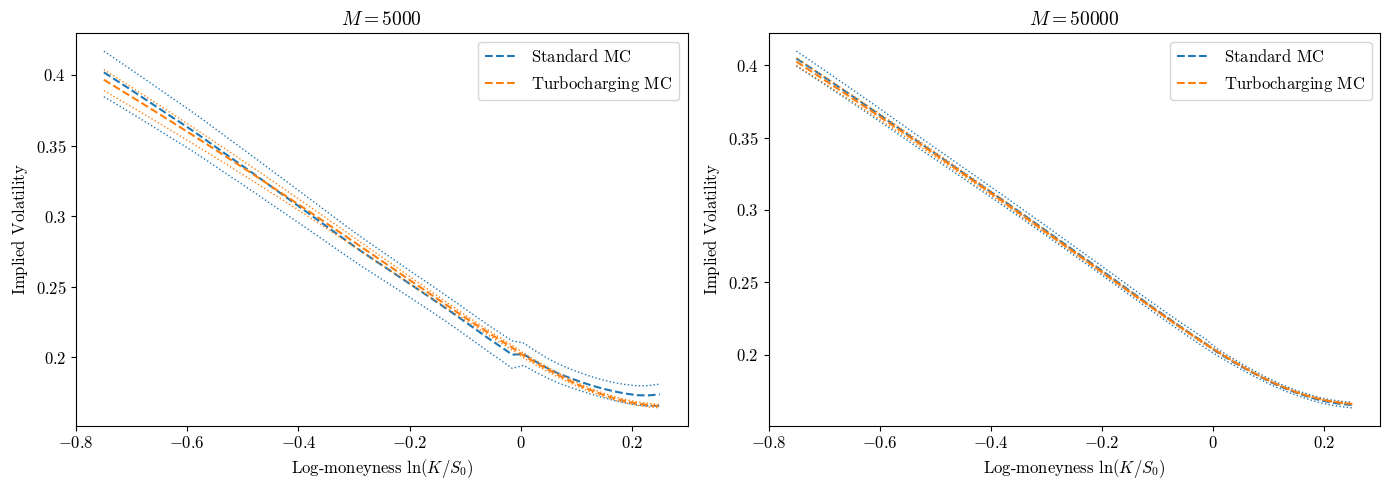

In [363]:
fig, ax = plt.subplots(1, 2, figsize = (14,5))

ax[0].plot(lm_range, iv_mc_5k, color = "tab:blue", linestyle = "--", label = r"$\text{Standard MC}$")
ax[0].plot(lm_range, iv_turbo_5k, color = "tab:orange", linestyle = "--", label = r"$\text{Turbocharging MC}$")
ax[0].plot(lm_range, iv_mc_lower_5k, color = "tab:blue", linestyle =":", lw=1)
ax[0].plot(lm_range, iv_mc_upper_5k, color = "tab:blue", linestyle =":", lw=1)
ax[0].plot(lm_range, iv_turbo_lower_5k, color = "tab:orange", linestyle =":", lw=1)
ax[0].plot(lm_range, iv_turbo_upper_5k, color = "tab:orange", linestyle =":", lw=1)
ax[0].set_title(r"$M = 5000$", fontsize=14)
ax[0].legend(fontsize=12)

ax[1].plot(lm_range, iv_mc_50k, color = "tab:blue", linestyle = "--", label = r"$\text{Standard MC}$")
ax[1].plot(lm_range, iv_turbo_50k, color = "tab:orange", linestyle = "--", label = r"$\text{Turbocharging MC}$")
ax[1].plot(lm_range, iv_mc_lower_50k, color = "tab:blue", linestyle =":", lw=1)
ax[1].plot(lm_range, iv_mc_upper_50k, color = "tab:blue", linestyle =":", lw=1)
ax[1].plot(lm_range, iv_turbo_lower_50k, color = "tab:orange", linestyle =":", lw=1)
ax[1].plot(lm_range, iv_turbo_upper_50k, color = "tab:orange", linestyle =":", lw=1)
ax[1].set_title(r"$M = 50000$", fontsize=14)
ax[1].legend(fontsize=12)

for i in range(2) : 
    ax[i].set_xlabel(r"$\text{Log-moneyness }\ln(K/S_0)$", fontsize=12)
    ax[i].set_ylabel(r"$\text{Implied Volatility}$", fontsize=12) 
    ax[i].tick_params(axis='both', labelsize=12)
    ax[i].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
    ax[i].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
    
plt.tight_layout()
plt.show()